In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV
import holidays

In [2]:
class dataTransformer:
    '''Transformer class to transform the data'''
    def __init__(self, col_name):
        self.featue_col = col_name
        
    def deriveSeasons(self, X):
        X['season'] = [month%12 // 3 + 1 for month in X[self.featue_col].dt.month]
        return X
        
    def deriveBusinessHrs(self, X):
        X['temp'] = [1 if ((x > 7) & (x < 18)) else 0 for x in X[self.featue_col].dt.hour]
        X['business_hrs'] = [1 if ((x['temp'] == 1) & (x['public_holiday'] == 0)) else 0 for _,x in X.iterrows()]
        return X
        
    def derivePublicHoliday(self, X):
        us_holidays = holidays.US()
        X['public_holiday'] = [1 if x in us_holidays else 0 for x in X[self.featue_col].dt.date]
        return X
    
    def deriveDayOfTheMonth(self, X):
        X['day_of_month'] = X[self.featue_col].dt.day
        return X
    
    def deriveDayOfTheYear(self, X):
        X['day_of_year'] = X[self.featue_col].dt.dayofyear
        return X
    
    def deriveDayOfWeek(self, X):
        X['day_of_week'] = X[self.featue_col].dt.dayofweek
        return X
    
    def deriveQuarter(self, X):
        X['quarter'] = X[self.featue_col].dt.quarter
        return X
    
    def deriveMonth(self, X):
        X['month'] = X[self.featue_col].dt.month    
        return X
    
    def deriveHour(self, X):
        X['hour'] = X[self.featue_col].dt.hour
        return X
    
    def deriveYear(self, X):
        X['year'] = X[self.featue_col].dt.year
        return X
    
    def deriveWeekOfYear(self, X):
        X['weekofyear'] = X[self.featue_col].dt.weekofyear
        return X
    
    def deriveIsWeekeend(self, X):
        X["Is_Weekend"] = X.Datetime.dt.day_name().isin(['Saturday', 'Sunday']).astype(int)
        return X
    
    def generated_lagged_features(self, X, var, max_lag, train = True):
        X['Count_lag1_1'] = X[var].shift(24*1)
        X['Count_lag1_2'] = X[var].shift(24*2)
        X['Count_lag1_3'] = X[var].shift(24*3)
        for t in range(1, max_lag+1):
            X[var+'_lag'+str(t)] = X[var].shift(24*7*t)
        return X
    
    def transform(self, X, train = True):
        X = self.derivePublicHoliday(X)
        X = self.deriveSeasons(X)
        X = self.deriveBusinessHrs(X)
        X = self.deriveDayOfTheMonth(X)
        X = self.deriveDayOfTheYear(X)
        X = self.deriveDayOfWeek(X)
        X = self.deriveQuarter(X)
        X = self.deriveMonth(X)
        X = self.deriveHour(X)
        X = self.deriveYear(X)
        X = self.deriveWeekOfYear(X)
        X = self.deriveIsWeekeend(X)
        if train == True:
            X = self.generated_lagged_features(X,'Count',24,train)
            X = X.dropna()
            feat = X[['day_of_month','day_of_year','day_of_week',
                      'hour','Is_Weekend', 'Count_lag1_1','Count_lag1_2','Count_lag1_3',
                 'Count_lag1','Count_lag2','Count_lag3','Count_lag4','Count_lag5','Count_lag6','Count_lag7',
                'Count_lag8','Count_lag9','Count_lag10','Count_lag11','Count_lag12','Count_lag13','Count_lag14',
                     'Count_lag15','Count_lag16','Count_lag17','Count_lag18','Count_lag19','Count_lag20',
                     'Count_lag21','Count_lag22','Count_lag23','Count_lag24']]
        else:
            feat = X[['day_of_month','day_of_year','day_of_week',
                      'hour','Is_Weekend']]
        if train:
            label = X[['Count']]
            return feat, label
        else:
            return feat

In [3]:
class model_def:
    def train_test_split(self, X, y, size = 0.20):
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=size)
        self.train_X = train_X
        self.test_X = test_X
        self.train_y = train_y
        self.test_y = test_y
        return
    
    def get_model(self):
        self.model = XGBRegressor(n_estimators = 12000, learning_rate=0.001, early_stopping_rounds = 50)
        return
    
    def fit_model(self, verbose=False):
        self.model.fit(self.train_X, self.train_y, 
             eval_set=[(self.test_X, self.test_y)], verbose=100)
        return
    
    def predict_future(self, test_df, y):
        self.predictions = []
        for _,x in test_df.iterrows():
            x['Count_lag1_1'] = y.iloc[[y.shape[0]-1-24*1]]['Count'].iloc[0]
            x['Count_lag1_2'] = y.iloc[[y.shape[0]-1-24*2]]['Count'].iloc[0]
            x['Count_lag1_3'] = y.iloc[[y.shape[0]-1-24*3]]['Count'].iloc[0]
            x['Count_lag1'] = y.iloc[[y.shape[0]-1-24*1*7]]['Count'].iloc[0]
            x['Count_lag2'] = y.iloc[[y.shape[0]-1-24*2*7]]['Count'].iloc[0]
            x['Count_lag3'] = y.iloc[[y.shape[0]-1-24*3*7]]['Count'].iloc[0]
            x['Count_lag4'] = y.iloc[[y.shape[0]-1-24*4*7]]['Count'].iloc[0]
            x['Count_lag5'] = y.iloc[[y.shape[0]-1-24*5*7]]['Count'].iloc[0]
            x['Count_lag6'] = y.iloc[[y.shape[0]-1-24*6*7]]['Count'].iloc[0]
            x['Count_lag7'] = y.iloc[[y.shape[0]-1-24*7*7]]['Count'].iloc[0]
            x['Count_lag8'] = y.iloc[[y.shape[0]-1-24*8*7]]['Count'].iloc[0]
            x['Count_lag9'] = y.iloc[[y.shape[0]-1-24*9*7]]['Count'].iloc[0]
            x['Count_lag10'] = y.iloc[[y.shape[0]-1-24*10*7]]['Count'].iloc[0]
            x['Count_lag11'] = y.iloc[[y.shape[0]-1-24*11*7]]['Count'].iloc[0]
            x['Count_lag12'] = y.iloc[[y.shape[0]-1-24*12*7]]['Count'].iloc[0]
            x['Count_lag13'] = y.iloc[[y.shape[0]-1-24*13*7]]['Count'].iloc[0]
            x['Count_lag14'] = y.iloc[[y.shape[0]-1-24*14*7]]['Count'].iloc[0]
            x['Count_lag15'] = y.iloc[[y.shape[0]-1-24*15*7]]['Count'].iloc[0]
            x['Count_lag16'] = y.iloc[[y.shape[0]-1-24*16*7]]['Count'].iloc[0]
            x['Count_lag17'] = y.iloc[[y.shape[0]-1-24*17*7]]['Count'].iloc[0]
            x['Count_lag18'] = y.iloc[[y.shape[0]-1-24*18*7]]['Count'].iloc[0]
            x['Count_lag19'] = y.iloc[[y.shape[0]-1-24*19*7]]['Count'].iloc[0]
            x['Count_lag20'] = y.iloc[[y.shape[0]-1-24*20*7]]['Count'].iloc[0]
            x['Count_lag21'] = y.iloc[[y.shape[0]-1-24*21*7]]['Count'].iloc[0]
            x['Count_lag22'] = y.iloc[[y.shape[0]-1-24*22*7]]['Count'].iloc[0]
            x['Count_lag23'] = y.iloc[[y.shape[0]-1-24*23*7]]['Count'].iloc[0]
            x['Count_lag24'] = y.iloc[[y.shape[0]-1-24*24*7]]['Count'].iloc[0]
            t = self.model.predict(pd.DataFrame(x).T)
            self.predictions.append(t)
            y = y.append(dict(zip(y.columns, t)), ignore_index=True)
        return
        
        # simple
        #self.predictions = self.model.predict(test_df)

In [4]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.001, 0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror'],
        'eval_metric': ['rmse']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,               
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [5]:
df_train = pd.read_csv('../Dataset/Train_SU63ISt.csv')
df_train['Datetime'] = pd.to_datetime(df_train['Datetime'])
transformer = dataTransformer(col_name='Datetime')
X, y = transformer.transform(df_train, train = True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [6]:
#hyperParameterTuning(X,y)

In [7]:
# best param
"""
{'colsample_bytree': 0.7,
 'eval_metric': 'rmse',
 'learning_rate': 0.001,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 200,
 'objective': 'reg:squarederror',
 'subsample': 0.5}
"""

"\n{'colsample_bytree': 0.7,\n 'eval_metric': 'rmse',\n 'learning_rate': 0.001,\n 'max_depth': 3,\n 'min_child_weight': 1,\n 'n_estimators': 200,\n 'objective': 'reg:squarederror',\n 'subsample': 0.5}\n"

In [8]:
model = model_def()
model.train_test_split(X, y)
model.get_model()
model.fit_model()

[08:39:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:233.028
[100]	validation_0-rmse:212.459
[200]	validation_0-rmse:194.013
[300]	validation_0-rmse:177.436
[400]	validation_0-rmse:162.524
[500]	validation_0-rmse:149.122
[600]	validation_0-rmse:137.089
[700]	validation_0-rmse:126.302
[800]	validation_0-rmse:116.633
[900]	validation_0-rmse:107.997
[1000]	validation_0-rmse:100.31
[1100]	validation_0-rmse:93.4537
[1200]	validation_0-rmse:87.3687
[1300]	validation_0-rmse:82.0079
[1400]	validation_0-rmse:77.3004
[1500]	validation_0-rmse:73.1858
[1600]	validation_0-rmse:69.6008
[1700]	validation_0-rmse:66.4558
[1800]	validation_0-rmse:63.7274
[1900]	validation_0-rmse:61.3911
[2000]	validation_0-rmse:59.3881
[2100]	validation_0-rmse:57.6728
[2200]	validation_0-rmse:56.2097
[2300]	validation_0-rmse:54.9657
[2400]	validation_0-rmse:53.9099
[2500]	validation_0-rmse:53.0207
[2600]	validation_0-rmse:52.254
[2700]	

In [9]:
df_test = pd.read_csv('../Dataset/Test_0qrQsBZ.csv')
df_test['Datetime'] = pd.to_datetime(df_test['Datetime'])

In [10]:
X_test = transformer.transform(df_test, train = False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [11]:
model.predict_future(X_test,y)

In [12]:
y = pd.DataFrame(model.predictions, columns = ['Count'])
final = pd.concat([df_test['ID'],y],axis=1)
final.to_csv('XG.csv',index=False)

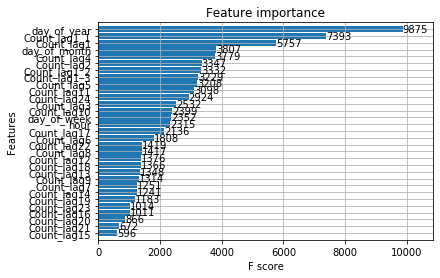

In [14]:
plot_importance(model.model, height=0.9)